<a href="https://colab.research.google.com/github/dlevonian/riiid-prediction/blob/master/submission_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resources

Kaggle competition: https://www.kaggle.com/c/riiid-test-answer-prediction/overview

Riiid research: https://arxiv.org/pdf/2010.12042

Attention Is All You Need: https://arxiv.org/abs/1706.03762


## Config

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/Riiid/'

Mounted at /content/drive


In [2]:
import sys
from psutil import virtual_memory
def check_memory():
    print(f'Available RAM:  {virtual_memory().available/1e9:.1f} GB   ',
          f'{100*virtual_memory().available/virtual_memory().total:.1f}%')
check_memory()

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import time
import datetime
import gc
import pickle

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from keras.layers import Embedding, Dense, Dropout, LayerNormalization
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.metrics import roc_auc_score, roc_curve

TIC=time.time()

Available RAM:  26.3 GB    96.2%


In [3]:
class Positions(object):
    def __init__(self, columns):
        for i, col in enumerate(columns): 
            setattr(self, col, i)

In [4]:
# ============== INTAKE
N_QUESTIONS = 13_523
REMOVE_LECTURES = True
LAG_BINS = [-1e8,0,0.1,5,10,15,20,25,30,35,40,50,60,70,80,90,100,125,150,200,300,500,3600,36000]
N_LAGBINS = len(LAG_BINS)
HIST_BINS = [1,13,28,51,83,124,173,232,302,385,484,604,749,929,1155,1446,1832,2382,3251,4945]
N_HISTBINS = len(HIST_BINS)

# ============== DATASET
WINDOW = 128
STEP = 96
BATCH_SIZE = 64
D_TYPE = tf.float32

# ============== TRANSFORMER
D_MODEL = 160
N_LAYERS = 2
N_HEADS = 8 
DFF = 2 * D_MODEL
DROPOUT = 0.1


## Data pipeline

### train

In [5]:
tic = time.time()
train_df = pd.read_pickle(path + 'data/train_z.pkl')

print(f'Loaded in {time.time()-tic:.1f} sec')
check_memory()

Loaded in 47.2 sec
Available RAM:  23.6 GB    86.5%


In [6]:
print(train_df.shape)
train_df.head()

(100230332, 11)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,virtual_ts
0,46,0,124,7900,0,0,0,1,NaN,<NA>,64972177101
1,47,32683,124,7876,0,1,0,0,26000.0,False,64972209784
2,48,62000,124,175,0,2,2,1,29000.0,False,64972239101
3,49,83632,124,1278,0,3,1,0,26000.0,False,64972260733
4,50,189483,124,2064,0,4,2,0,18000.0,False,64972366584


In [7]:
def process_df(df, remove_lectures=REMOVE_LECTURES):

    df = df[['user_id','content_id','content_type_id','answered_correctly','timestamp']]
    df = df.rename(columns={'content_id':'question_id', 'answered_correctly':'y_true'})

    if remove_lectures:  df = df[df.content_type_id==0].drop('content_type_id',axis=1)
    
    user_total=[1 + np.arange(c) for c in df.user_id.value_counts().sort_index()]
    df['user_total'] = np.concatenate(user_total)
  
    return df

In [8]:
tic=time.time()
assert train_df.user_id.is_monotonic
train_df = process_df(train_df)

print(f'done in {time.time()-tic:.1f} sec')
gc.collect()
check_memory()

done in 8.6 sec
Available RAM:  21.5 GB    78.5%


In [9]:
print(train_df.shape)
train_df.head()

(98288968, 5)


,user_id,question_id,y_true,timestamp,user_total
0,124,7900,1,0,1
1,124,7876,0,32683,2
2,124,175,1,62000,3
3,124,1278,0,83632,4
4,124,2064,0,189483,5


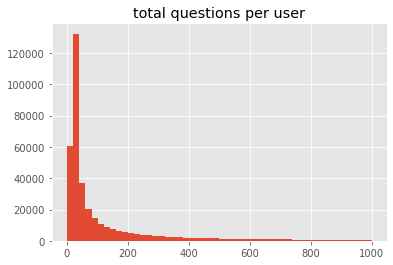

In [10]:
vc = train_df.user_id.value_counts()
plt.hist(vc[vc < 1000], bins=50)
plt.title('total questions per user');

In [11]:
def add_repeat_questions(df):
    """Adds 'repeat question' flag for each intercation.
    """
    user_idx = np.cumsum(df.user_id.value_counts().sort_index().values)
    split_qids = np.split(df.question_id.values, user_idx[:-1])

    unique_users = df.user_id.nunique()
    assert unique_users==len(split_qids)
    
    tic = time.time()
    repeat = []
    for user, arr in enumerate(split_qids):
        rq = np.zeros_like(arr, dtype=int)
        seen = set()
        for i, el in enumerate(arr):
            if el in seen: rq[i] = 1
            seen.add(el)
        repeat.append(rq)
        print(f'\rprocessed {100*user/unique_users:.1f}%   {time.time()-tic:.1f} sec',end='')        

    df['repeat']=np.concatenate(repeat)
    return df


train_df = add_repeat_questions(train_df)

processed 100.0%   98.1 sec

In [12]:
train_df.head()

,user_id,question_id,y_true,timestamp,user_total,repeat
0,124,7900,1,0,1,0
1,124,7876,0,32683,2,0
2,124,175,1,62000,3,0
3,124,1278,0,83632,4,0
4,124,2064,0,189483,5,0


In [13]:
print(f'% answered correctly: \t{100*train_df.y_true.mean():.1f}%')
print(f'% repeat questions: \t{100*train_df.repeat.mean():.1f}%')

% answered correctly: 	65.7%
% repeat questions: 	12.5%


In [14]:
train_df.to_pickle(path+'data/train_6_features.pkl')

Shortcut

In [15]:
train_df = pd.read_pickle(path+'data/train_6_features.pkl')

In [16]:
train_df.head()

,user_id,question_id,y_true,timestamp,user_total,repeat
0,124,7900,1,0,1,0
1,124,7876,0,32683,2,0
2,124,175,1,62000,3,0
3,124,1278,0,83632,4,0
4,124,2064,0,189483,5,0


In [17]:
df_po = Positions(list(train_df.columns))

df_po.user_id, df_po.question_id, df_po.repeat # verify

(0, 1, 5)

### valid, questions

In [18]:
# OOS 1 M latest interactions
valid_df = pd.read_pickle(path+'data/valid_z.pkl')

In [19]:
print(valid_df.shape)
valid_df.head()

(1000000, 11)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,virtual_ts
100230332,82709321,74222766693,1761102725,8608,0,449,3,1,17000.0,True,84671806026
100230333,9037236,882114880,196648614,837,0,157,3,1,18000.0,True,84671806601
100230334,53897867,19913,1142830055,7876,0,1,3,1,15000.0,False,84671811211
100230335,101147865,2528934977,2146039389,6422,0,423,3,1,14000.0,True,84671812525
100230336,19504563,361898252,419295431,1087,0,140,3,0,17000.0,True,84671816665


In [20]:
question_df = pd.read_csv(path + 'data/questions_enhanced.csv')
question_df['section'] = (question_df.part > 4).astype(int)  # Listening = 0,   Reading = 1

SECTIONS_DICT = {k: v for k, v in zip(question_df.question_id, question_df.section)}
PARTS_DICT = {k: v for k, v in zip(question_df.question_id, question_df.part)}

print(question_df.shape)
question_df.head(1)

(13523, 16)


,question_id,bundle_id,correct_answer,part,tags,Wrong,Right,pct_question,n_tags,t1,t2,t3,t4,t5,t6,section
0,0,0,0,1,51 131 162 38,637,6266,0.907721,4,51,131,162,38,0,0,0


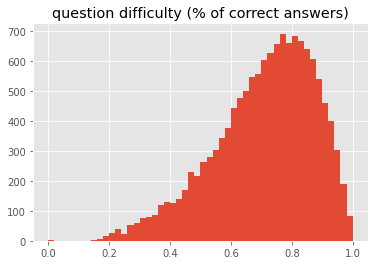

In [21]:
plt.hist(question_df.pct_question, bins=50)
plt.title('question difficulty (% of correct answers)');

In [22]:
# QCP_HIST: an array of question difficulty [question_id, history_bin]
QCP_HIST = pd.read_csv(path + 'data/qcp_hist.csv')
QCP_HIST = QCP_HIST.values
print(QCP_HIST.shape)

(13523, 21)


In [23]:
check_memory()

Available RAM:  14.3 GB    52.4%


### dataset

In [24]:
ds_features = ['question_id', 'repeat', 'lag', 'qcp', 'y_roll', 'y_true']

ds_po = Positions(ds_features)

F_WIDTH = len(ds_features)  # width of the transformer input
print(f'F_WIDTH: {F_WIDTH}')

F_WIDTH: 6


In [25]:
def prepare_features(arr, 
                     po=df_po, 
                     lag_bins=LAG_BINS, 
                     hist_bins=HIST_BINS, 
                     n_q=N_QUESTIONS, 
                     qcp_hist=QCP_HIST):
    
    # df_po:  user_id	question_id	y_true	timestamp	user_total	repeat

    question_id = arr[:,po.question_id]
    repeat      = arr[:,po.repeat]

    lag = arr[:,po.timestamp] - np.roll(arr[:, po.timestamp], shift=1, axis=0)
    lag = np.digitize(lag/1_000, lag_bins)

    history = np.digitize(arr[:, po.user_total], hist_bins)

    qcp = np.array([qcp_hist[int(q), int(h)] for q, h in zip(question_id, history)])

    #replace question #0 with N_Q (for 0-based masking purposes)
    question_id[question_id == 0] = n_q  
    
    y_true   = arr[:,po.y_true]
    y_roll   = np.roll(y_true, shift=1, axis=0)
    y_roll[0]=1
    
    # ds_features = ['question_id', 'lag', 'qcp', 'y_roll', 'y_true']
    arr = np.concatenate([question_id.reshape(-1, 1),
                          repeat     .reshape(-1, 1),
                          lag        .reshape(-1, 1),
                          qcp        .reshape(-1, 1),
                          y_roll     .reshape(-1, 1),
                          y_true     .reshape(-1, 1),
                          ], axis=1)
    assert arr.ndim==2
    return arr.astype(np.float32)


def windowed_arr(arr, window, step):
    """Produces a windowed 3D array from a flat 2D array.
       (same as tf.dataset.window)
    """
    output = [] 
    for i in range((arr.shape[0] - 1) // step + 1): # number of overlapping windows
        w = arr[-i * step - window : arr.shape[0] - i * step]
        w = np.pad(w, ((0,window - w.shape[0]),(0, 0)))
        w = np.expand_dims(w, axis=0)
        output.append(w)
    
    if len(output) == 1: 
        output = output[0]
    else:
        output = np.concatenate(output)

    assert output.ndim == 3
    return output.astype(np.float32) 


def get_last_t(el):
    """Identifies number of meaningful (non-zero) elements in the batch.
    Args: 
        el: (batch, seq, features) 
    Returns:
        last_t: scalar number of non-zero elements
    """    
    nonzeros = tf.cast(tf.math.not_equal(el[:, :, 0], 0), tf.int32)
    last_t = tf.math.reduce_sum(nonzeros, axis=-1) - 1
    return last_t 


def shuffle_feature(arr, pos):
    # for permutation f.i.
    f_slice = arr[:,:,pos].copy()
    f_shuffled = f_slice.reshape(-1)
    np.random.shuffle(f_shuffled)
    arr[:,:,pos] = f_shuffled.reshape(f_slice.shape)
    return arr


In [26]:
tic = time.time()
wf = []

user_idx = np.cumsum(train_df.user_id.value_counts().sort_index().values)
user_idx = np.concatenate([[0], user_idx])
unique_users = train_df.user_id.nunique()

assert unique_users == len(user_idx) - 1

for i in range(unique_users):

    features = train_df[user_idx[i]:user_idx[i+1]].values.astype(np.float32)

    features = prepare_features(features)
    features = windowed_arr(features, WINDOW, STEP)

    wf.append(features)
    
    if (i + 1) % 10 == 0: 
        print(f'\rprocessed {100*i/unique_users:.1f}%  {time.time()-tic:.1f} sec', end='')

wf = np.concatenate(wf)

n_samples = wf.shape[0]
assert wf.shape[-1]==F_WIDTH

print(f'\nFeatures: {wf.shape}')
print(f'\nTotal samples: {n_samples:,}')

processed 100.0%  394.5 sec
Features: (1255455, 128, 6)

Total samples: 1,255,455


In [27]:
print(f'{sys.getsizeof(wf):,}')
wf = tf.cast(wf, tf.float32)

3,856,757,888


In [28]:
ds = tf.data.Dataset.from_tensor_slices(wf)
ds = ds.shuffle(n_samples)  # buffer size: the entire dataset
ds = ds.batch(BATCH_SIZE, drop_remainder=True)

# del wf
# gc.collect()
check_memory()

Available RAM:  10.2 GB    37.2%


In [29]:
print(ds.element_spec)

TensorSpec(shape=(64, 128, 6), dtype=tf.float32, name=None)


In [30]:
VAL_BATCHES = 100

train_ds = ds.skip(VAL_BATCHES)
val_ds   = ds.take(VAL_BATCHES)

train_batches = n_samples//BATCH_SIZE - VAL_BATCHES
print(f'Train batches: {train_batches:,}')
print(f'Valid batches: {VAL_BATCHES:,}')

Train batches: 19,516
Valid batches: 100


In [31]:
print(f'{time.time()-TIC:.1f} sec')

649.2 sec


## Transformer

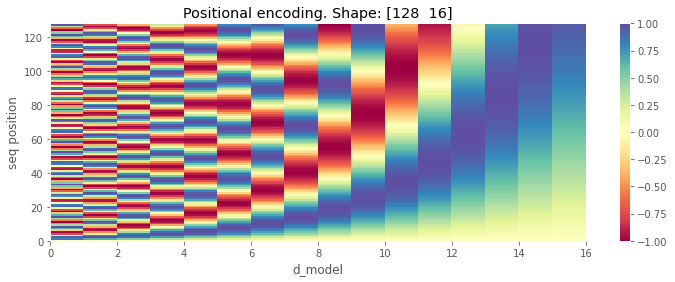

In [32]:
def positional_encoding(seq_len=WINDOW, d_pos=16, min_rate=1e-2):
    angle_rates = min_rate**(np.linspace(0,1,int(d_pos)))
    # cartesian position * angle_rates
    angles = np.arange(seq_len)[:, np.newaxis] * angle_rates[np.newaxis, :]  
    return tf.cast(np.sin(angles), dtype=D_TYPE)

plt.figure(figsize=(12,4))
plt.pcolormesh(positional_encoding(), cmap='Spectral')
plt.title(f'Positional encoding. Shape: {tf.shape(positional_encoding())}') 
plt.xlabel('d_model'); plt.ylabel('seq position'); plt.colorbar(); plt.show()

In [33]:
def decoder_mask(seq):
    padding_mask = tf.cast(tf.math.equal(seq, 0), D_TYPE)[:, tf.newaxis, tf.newaxis, :]
    seq_len = tf.shape(seq)[-1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=D_TYPE), -1, 0)
    return tf.maximum(padding_mask, look_ahead_mask)

def QKV_attention(Q, K, V, mask):
    QK = tf.matmul(Q, K, transpose_b=True) 
    scaled_QK = QK / tf.math.sqrt( tf.cast(tf.shape(K)[-1], dtype=D_TYPE) )
    scaled_QK = scaled_QK + mask*-1e9
    attn_weights = tf.nn.softmax(scaled_QK, axis=-1)
    attn_output = tf.matmul(attn_weights, V)
    return attn_output

class MHA(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model%n_heads==0
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_head  = tf.cast(d_model/n_heads, tf.int32)  
        # Linear fully-coonected projection layers Z->QKV
        self.linear_q = Dense(d_model)
        self.linear_k = Dense(d_model)
        self.linear_v = Dense(d_model)
        # Final linear layer that links concatenated heads to the d_model-dimensional output
        self.linear_output = Dense(d_model)
        
    def call(self, Q, K, V, mask):
        batch_size =  tf.shape(Q)[0]
        Q = self.linear_q(Q)  # (batch_size, seq_len_q, d_model)
        K = self.linear_k(K)  # (batch_size, seq_len, d_model)
        V = self.linear_v(V)  # (batch_size, seq_len, d_model)
        # Split d_model into heads:  (batch_size, seq_len_q, num_heads, d_head)
        Q = tf.reshape(Q, (batch_size, -1, self.n_heads, self.d_head))
        K = tf.reshape(K, (batch_size, -1, self.n_heads, self.d_head))
        V = tf.reshape(V, (batch_size, -1, self.n_heads, self.d_head))
        # QKV_attention needs seq_len in the -2 position: (batch_size, num_heads, seq_len, d_head)
        Q = tf.transpose(Q, perm=[0, 2, 1, 3])
        K = tf.transpose(K, perm=[0, 2, 1, 3])
        V = tf.transpose(V, perm=[0, 2, 1, 3])
        # apply QKV_attention to each head. (batch_size, num_heads, seq_len_q, d_head)
        output = QKV_attention(Q, K, V, mask)
        # Bring num_heads into penultimate position and concatenate back to get num_heads * d_head = d_model
        output = tf.transpose(output, perm=[0, 2, 1, 3])            # (batch_size, seq_len_q, num_heads, d_head)
        output = tf.reshape(output, (batch_size, -1, self.d_model)) # (batch_size, seq_len_q, d_model)
        output = self.linear_output(output)  # (batch_size, seq_len_q, d_model)
        return output    

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate): 
        super().__init__()

        self.mha = MHA(d_model, n_heads)
        self.dense_relu = Dense(dff, activation='relu')
        self.linear = Dense(d_model)
        
        # dropout to be implemented before adding residual and normalization
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

        # Layer Norm. -- normalize activations across features (d_model) within each x
        # A functional transpose of the Batch Norm, which normalizes each feature across all x in a batch
        # By deafault, applied to last dimension of the tensor. Epsilon is added to the variance to avoid dividing by 0.
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
    
    def call(self, x, mask, training):

        # Encoder self-attention uses the same input x for Q, K, V
        # All steps produce the same output shape  (batch_size, seq_len, d_model)
        self_attn = self.mha(x, x, x, mask)

        # Dropout training: True in training mode (w/ dropout), False in inference mode (no dropout)
        self_attn = self.dropout1(self_attn, training=training) 
        self_attn = self.layernorm1(self_attn + x)  # add residual connection and normalize
        
        # feed-forward part - first expanding to DFF, then brining back to D_MODEL
        output = self.dense_relu(self_attn)
        output = self.linear(output)

        output = self.dropout2(output, training=training) 
        output = self.layernorm2(output + self_attn)  # add residual connection and normalize
        
        return output  # shape=(batch_size, seq_len, d_model)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dff, dropout_rate):
        super().__init__()

        self.mha1 = MHA(d_model, n_heads)
        self.mha2 = MHA(d_model, n_heads)

        self.dense_relu = Dense(dff, activation='relu')
        self.linear = Dense(d_model)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        
    def call(self, x, enc_output, mask, training):
        # All steps produce the same output shape  (batch_size, target_seq_len, d_model)
        # cross_attn uses enc_output (batch_size, input_seq_len, d_model)

        self_attn = self.mha1(x, x, x, mask)  # 
        self_attn = self.dropout1(self_attn, training=training)
        self_attn = self.layernorm1(self_attn + x)
        
        # Q, K, V order for cross_attn inputs: only Q comes from within the decoder
        cross_attn = self.mha2(self_attn, enc_output, enc_output, mask)
        cross_attn = self.dropout2(cross_attn, training=training)
        cross_attn = self.layernorm2(cross_attn + self_attn)
        
        # feed-forward part - first expanding to DFF, then brining back to D_MODEL
        output = self.dense_relu(cross_attn)
        output = self.linear(output)
        
        output = self.dropout3(output, training=training) 
        output = self.layernorm3(output + cross_attn)  # add residual connection and normalize
        
        return output

class Encoder(tf.keras.layers.Layer):
    def __init__(self, window, n_layers, d_model, n_heads, dff, dropout_rate,
                 n_questions, n_lagbins, n_histbins, po):
        super().__init__()
        self.n_layers = n_layers

        self.dropout = Dropout(dropout_rate)        
        self.enc_layers = [EncoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]

    def call(self, x, mask, training):

        x = self.dropout(x, training=training)

        for i in range(self.n_layers):  
            x = self.enc_layers[i](x, mask, training)

        return x  # (batch_size, seq_len, d_model)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, 
                 window, n_layers, d_model, n_heads, dff, dropout_rate,
                 n_questions, n_lagbins, n_histbins, po):
        super().__init__()

        self.n_layers = n_layers
        self.dropout = Dropout(dropout_rate)        
        self.dec_layers = [DecoderLayer(d_model, n_heads, dff, dropout_rate) for _ in range(n_layers)]
       
    def call(self, x, enc_output, mask, training):

        x = self.dropout(x, training=training)

        for i in range(self.n_layers):  
            x = self.dec_layers[i](x, enc_output, mask, training)

        return x # (batch_size, seq_len, d_model)        


class Transformer(tf.keras.Model):

    def __init__(self, 
                 window, n_layers, d_model, n_heads, dff, dropout_rate,
                 n_questions, n_lagbins, n_histbins, po):
        """ Intitializes the embedding layers, Encoder, Decoder, final sigmoid output.

            Make room for vacant_depth, part of d_model which is
                - NOT used by question embedding
                - instead, used for concatenating the other variables
            E.g. vacant_depth = 7 to make room for:
            - lag, embedding dims=4
            - repeat, qcp, y_roll, each with dims=1
        """
        super().__init__()
        self.window = window
        self.d_model  = d_model
        self.po = po

        self.vacant_depth = 7

        self.emb = Embedding(n_questions+1, self.d_model-self.vacant_depth, mask_zero=True)  
        self.emb_lag = Embedding(n_lagbins+1, 4)

        self.encoder = Encoder(window, n_layers, d_model, n_heads, dff, dropout_rate,
                               n_questions, n_lagbins, n_histbins, po)
        self.decoder = Decoder(window, n_layers, d_model, n_heads, dff, dropout_rate,
                               n_questions, n_lagbins, n_histbins, po)
        self.final_sigmoid = Dense(1, activation='sigmoid')

        
    def call(self, batch, training):

        batch = tf.cast(batch, tf.float32)
        
        # MAKE SURE FEATURE 0 DOES NOT HAVE ZEROS EXCEPT FOR PADDING:
        mask = decoder_mask(batch[:,:,0])  

        question_id = batch[:,:, self.po.question_id]
        question_id = self.emb(question_id)  
        
        pos = positional_encoding(d_pos=self.d_model-self.vacant_depth)
        question_id = question_id + pos

        lag = batch[:,:, self.po.lag]   
        lag = self.emb_lag(lag) 

        # repeat, qcp, y_roll -- scalars
        repeat = batch[:,:, self.po.repeat]
        repeat = tf.expand_dims(repeat, axis=2) # (batch_size, seq_len, 1)

        qcp = batch[:,:, self.po.qcp]
        qcp = tf.expand_dims(qcp, axis=2)   # (batch_size, seq_len, 1)

        y_roll = batch[:,:, self.po.y_roll]
        y_roll = tf.expand_dims(y_roll, axis=2)   # (batch_size, seq_len, 1)
        
        x = tf.concat([question_id, lag, repeat, qcp, y_roll], axis=2)

        enc_output = self.encoder(x, mask, training)  # (batch_size, inp_seq_len, d_model)
        dec_output = self.decoder(x, enc_output, mask, training) # (batch_size, tar_seq_len, d_model)
        output = self.final_sigmoid(dec_output)

        return   tf.squeeze(output)  # (batch_size, tar_seq_len)


In [34]:
# Verify comp.graph
trans_temp = Transformer(WINDOW, N_LAYERS, D_MODEL, N_HEADS, DFF, DROPOUT, 
                         N_QUESTIONS, N_LAGBINS, N_HISTBINS, ds_po) 

x = tf.random.uniform((BATCH_SIZE, WINDOW, F_WIDTH))  # (batch, seq, features)
trans_out = trans_temp(x, training=False)
print('Transformer output:', trans_out.shape)

# Transformer model size
n_weights = sum([np.product(w.shape) for w in trans_temp.trainable_weights])
print(f'Total transformer weights:  {n_weights:,}')

Transformer output: (64, 128)
Total transformer weights:  3,102,393


## Generator


Forked from this great notebook: https://www.kaggle.com/its7171/time-series-api-iter-test-emulator

In [35]:
class IterValid(object):

    def __init__(self, df, max_user=1000):
        """
        General worflow:
            ITERATOR (this class) --> df (test_df) -->  MODEL --> sample_df (sample_prediction_df)
        """
        # test_df, the yield of the iterator
        df = df [['row_id','timestamp','user_id','content_id','content_type_id','task_container_id',
                  'user_answer', 'answered_correctly',
                  'prior_question_elapsed_time','prior_question_had_explanation']]
        df = df.reset_index(drop=True)
        self.df = df

        self.user_answer = df['user_answer'].astype(str).values
        self.answered_correctly = df['answered_correctly'].astype(str).values

        # 2 new columns in the iterator yield (=the input to the model)
        df['prior_group_responses'] = "[]"
        df['prior_group_answers_correct'] = "[]"
        
        # submission format: 2 columns: 
        #  row_id        answered_correctly (y_hat probability)
        self.sample_df = df[df['content_type_id'] == 0][['row_id']]
        self.sample_df['answered_correctly'] = 0.65

        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self

    def fix_df(self, 
               user_answer_list, answered_correctly_list, 
               pre_start   # previous group's start position (first row)
               ):
        
        df= self.df[pre_start:self.current].copy()

        sample_df = self.sample_df[pre_start:self.current].copy()

        df.loc[pre_start,'prior_group_responses'] = '[' + ",".join(self.pre_user_answer_list) + ']'
        df.loc[pre_start,'prior_group_answers_correct'] = '[' + ",".join(self.pre_answered_correctly_list) + ']'
        
        df.drop(['user_answer', 'answered_correctly'],axis=1, inplace=True)

        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):

        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1
        pre_content_type_id = -1
        user_answer_list = []
        answered_correctly_list = []        
        
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]

            # Each group will contain interactions from many different users, 
            # but no more than one task_container_id of questions from any single user. 
            if crr_user_id in added_user and (crr_user_id != pre_added_user or (crr_task_container_id != pre_task_container_id and crr_content_type_id == 0 and pre_content_type_id == 0)):
                # known user(not prev user or (differnt task container and both question))
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            
            # Each group has between 1 and 1000 users.
            if len(added_user) == self.max_user:
                if  crr_user_id == pre_added_user and (crr_task_container_id == pre_task_container_id or crr_content_type_id == 1):
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(self.answered_correctly[self.current])
                    self.current += 1
                    continue
                else:
                    return self.fix_df(user_answer_list, answered_correctly_list, pre_start)

            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            pre_content_type_id = crr_content_type_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()            


## Tracers

In [36]:

class UserTracer(object):

    def __init__(self, window=WINDOW, po=df_po):
        
        self.window = window
        self.po=po 
        self.db = dict()

    def from_df(self, train_df): 

        unique_users = train_df.user_id.unique()
        user_idx = np.cumsum(train_df.user_id.value_counts().sort_index().values)
        split_features = np.split(train_df.values, user_idx[:-1])
        assert len(unique_users) == len(split_features)

        for i, user in enumerate(unique_users):
            
            uf = split_features[i]  # user features
            uf = uf[uf[:,self.po.timestamp].argsort()]   # sort by timestamp
            uf = uf[-self.window-1:,:] # take last (window+1) timesteps
            
            self.db[user] = uf # create entry

            assert len(uf)<=self.window+1
            assert user==int(uf[0,self.po.user_id])

        return self


    def add_row(self, row):
        """ Input: from the validation cycle, a 1D row
            If user exists in DB:   append the row to the user_window
                            else:   create a new key and add row as the starting user_window
        """
        expanded_row = np.array(row).reshape(1,-1)
        user = row[self.po.user_id]
       
        if user in self.db.keys():
            uf = self.db[user]
            assert row[self.po.timestamp] >= max(uf[:,self.po.timestamp])  # timestamp integrity
            self.db[user] = np.concatenate((uf, expanded_row), axis=0)[-self.window-1:]

        else:
            self.db[user] = expanded_row

    def get_window(self, user):
        """Returns the window of the shape (1, WINDOW, F_WIDTH)
           if ut-native feature window is shorter, pad with zeros
        """
        uf = self.db[user].copy()
        uf = prepare_features(uf, self.po)
        uf = uf[-self.window:]
        
        assert uf.shape[0]<=self.window

        # pad extra zeros to dimension_0 if necessary
        uf = np.pad(uf, ((0,self.window-uf.shape[0]),(0,0)))  
        uf = np.expand_dims(uf, axis=0)
       
        assert uf.ndim==3
        return uf


    def from_pickle(self, file_path):
        tic=time.time()
        with open(file_path, 'rb') as handle:
            self = pickle.load(handle)
        print(f'done in {time.time()-tic:.1f} sec')        
        return self


    def to_pickle(self, file_path):
        tic=time.time()
        with open(file_path, 'wb') as handle:
            pickle.dump(self, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'done in {time.time()-tic:.1f} sec')        



class QuestionTracer(object):

    def __init__(self, po=df_po):
        
        self.po=po 
        self.eq = dict()  # eq: user's encountered questions

    def from_df(self, train_df): 
        unique_users = train_df.user_id.unique()
        user_idx = np.cumsum(train_df.user_id.value_counts().sort_index().values)
        split_features = np.split(train_df.question_id.values, user_idx[:-1])
        assert len(unique_users) == len(split_features)

        for i, user in enumerate(unique_users):
            self.eq[user] = split_features[i]   # encountered questions
        return self


    def add_eq(self, user, question):
        if user in self.eq.keys():  
            self.eq[user] = np.concatenate((self.eq[user], [question]))
        else:
            self.eq[user]=np.array([question])


    def check_eq(self, user, question):
        check=False
        if user in self.eq.keys() and question in self.eq[user]: check=True
        return check


    def from_pickle(self, file_path):
        tic=time.time()
        with open(file_path, 'rb') as handle:
            self = pickle.load(handle)
        print(f'done in {time.time()-tic:.1f} sec')        
        return self


    def to_pickle(self, file_path):
        tic=time.time()
        with open(file_path, 'wb') as handle:
            pickle.dump(self, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f'done in {time.time()-tic:.1f} sec')        


In [37]:
# ut_0 = UserTracer().from_df(train_df)
# ut = UserTracer().from_pickle(path+'data/ut_master.pkl')

## OOS Validation

In [38]:
oos_valid_df = valid_df[:100_000]
oos_valid_users = oos_valid_df.user_id.unique()
oos_valid_traces = train_df[train_df.user_id.isin(oos_valid_users)]

In [39]:
def oos_validate(transformer,
                 valid_df, 
                 valid_traces, 
                 df_po=df_po,
                 shuffle_pos=None,
                 remove_lectures=REMOVE_LECTURES, 
                 hist_bins=HIST_BINS,
                 qcp_hist=QCP_HIST,
                 ):
    tic=time.time()

    iter_test = IterValid(valid_df, max_user=1000)

    ut = UserTracer().from_df(valid_traces)
    qt = QuestionTracer().from_df(valid_traces)
    
    if remove_lectures: valid_df=valid_df[valid_df.content_type_id==0]
    total_length = len(valid_df)
    group_length=[]  # iterator groups

    predicted = []  # to accumulate predictions
    wls = []        # to accumulate window lengths (before padding)

    prior_group= None

    for (current_group,_) in iter_test:

        # ======== ACCESS THE PRIOR CORRECT ANSWERS, UPDATE THE DATABASE    

        if prior_group is not None:
            prior_group['correct'] = eval(current_group.prior_group_answers_correct.iloc[0])
            
            prior_group = prior_group[prior_group.content_type_id==0]

            # riiid rules: no more than one task_container_id of questions from any single user            
            for user_id in prior_group.user_id.unique():

                user_group = prior_group[prior_group.user_id==user_id]
                y_true = user_group.correct.values
                ut.db[user_id][-len(y_true):, df_po.y_true] = y_true  

        prior_group = current_group.copy()

        # ======== ADD NEW ROWS, RETRIEVE WINDOWED FEATURES
        x_group = []

        current_group=current_group[current_group.content_type_id==0]

        if len(current_group)==0: continue
        
        # current_group.prior_question_had_explanation.fillna(0, inplace=True)

        for _, row in current_group.iterrows():
            
            user     = row.user_id
            question = row.content_id
            
            user_total = ut.db[user][-1,df_po.user_total]+1 if user in ut.db.keys() else 1
            history = np.digitize(user_total, hist_bins)
            
            repeat = 1 if qt.check_eq(user, question) else 0 
            qt.add_eq(user, question)
            
            po_dict = { 
                df_po.y_true      : qcp_hist[int(question),int(history)],
                df_po.user_id     : user,
                df_po.question_id : question,
                df_po.repeat      : repeat,
                df_po.timestamp   : row.timestamp,
                df_po.user_total  : user_total,     # to be rolled inside prepare_features
            }

            assert len(po_dict)==len(df_po.__dict__)
            ut.add_row([po_dict[k] for k in sorted(po_dict.keys())])
            
            uf = ut.get_window(row.user_id)  
            x_group.append(uf)

        # ======== PREDICT WITH TRANSFORMER
        x_group = np.concatenate(x_group).astype(np.float32)
        if shuffle_pos is not None: x_group = shuffle_feature(x_group, shuffle_pos)
       
        y_group = transformer(x_group, training=False)
        if y_group.ndim==1: y_group=np.expand_dims(y_group, axis=0)  #for the rare groups of 1 row

        wl = get_last_t(x_group)  # wl: window length (before padding)
        current_group['answered_correctly'] = tf.gather(y_group, wl, batch_dims=1, axis=1)
        predicted.append(current_group.loc[:,['row_id','user_id','answered_correctly']]) 
        # KAGGLE:  env.predict(current_group.loc[:, ['row_id', 'answered_correctly']])

        wls.append(wl)
        group_length.append(len(current_group))
        print(f'\rProcessed: {100*sum(group_length)/total_length:.1f}%  {time.time()-tic:.1f} sec',end='')

    predicted = pd.concat(predicted)
    predicted = predicted.rename(columns={'answered_correctly': 'y_pred'})
    predicted['y_true'] = valid_df.answered_correctly.values
    predicted['wl'] = np.concatenate(wls)

    return predicted



## Train

### Setup

In [40]:
LOAD_MODEL = False

if LOAD_MODEL:
    save_path = path + 'saved_models/' +'x9_unified_2021_01_03_22_18_ep_2'
    transformer = tf.keras.models.load_model(save_path)

    # verify the computational graph
    x = tf.random.uniform((BATCH_SIZE, WINDOW, F_WIDTH))  # (batch, seq, features)
    trans_out = transformer(x, training=False)
    print('Transformer output:', trans_out.shape)

    # check model size
    n_weights = sum([np.product(w.shape) for w in transformer.trainable_weights])
    print(f'Total transformer weights:  {n_weights:,}')

else:
    transformer = Transformer(WINDOW, N_LAYERS, D_MODEL, N_HEADS, DFF, DROPOUT, 
                          N_QUESTIONS, N_LAGBINS, N_HISTBINS, ds_po)    

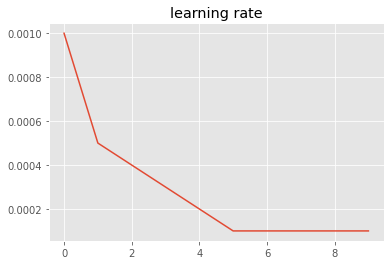

In [41]:
MODEL_NAME = 'a0_best'

EPOCHS = 5

REPORT_FREQ  = 500
VAL_FREQ     = 5_000 

OOS_VAL_FREQ = train_batches  # at the end of each epoch
CHKP_FREQ    = train_batches  # at the end of each epoch

CHKP_RESTORE = False
SAVE_EPOCH   = True

LR = [1e-3, 5e-4, 4e-4, 3e-4, 2e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, ]
plt.plot(LR); plt.title('learning rate');

tf.GradientTape API: https://www.tensorflow.org/guide/autodiff#gradient_tapes

TensorFlow provides the tf.GradientTape API for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually tf.Variables. 

TensorFlow "records" relevant operations executed inside the context of a tf.GradientTape onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [42]:
optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

train_loss = tf.keras.metrics.Mean(name='train_loss', dtype=tf.float32)

# The @tf.function trace-compiles train_step into a TF graph for faster execution.
@tf.function(input_signature=[
                    tf.TensorSpec(shape=(BATCH_SIZE, WINDOW, F_WIDTH), 
                                  dtype=D_TYPE)
                    ],
             experimental_relax_shapes=True)
def train_step(batch, po=ds_po):  

    with tf.GradientTape() as tape:
        
        y_true = batch[:, :, po.y_true] 
        y_pred = transformer(batch, training=True)
        
        loss = binary_crossentropy(y_true, y_pred)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)   
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)


In [43]:
# TensorBoard
log_dir = path + f'tensorboard/{MODEL_NAME}' + datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
train_summary_writer = tf.summary.create_file_writer(log_dir)
print(f'Recording tf.summary data into {log_dir}')

# Checkpoints
chkp = tf.train.Checkpoint(optimizer=optimizer, transformer=transformer)
chkp_manager = tf.train.CheckpointManager(chkp, path+f'checkpoints/{MODEL_NAME}', max_to_keep=10)

if CHKP_RESTORE:  # Restart training from the latest checkpoint, if exists
    chkp.restore(chkp_manager.latest_checkpoint)
    print(f'Latest checkpoint loaded: {chkp_manager.latest_checkpoint}')

Recording tf.summary data into /content/drive/My Drive/Riiid/tensorboard/a0_best20211129_020551


### Cycle

In [44]:
print (80*'='); print(f'GLOBAL TIME: {time.time()-TIC:.1f} sec'); print(80*'=')

val_AUCs=[]
oos_val_AUCs=[]

tic = time.time()

for epoch in range(EPOCHS):
    
    K.set_value(optimizer.lr, LR[epoch]) # set learning rate

    for i, batch in enumerate(train_ds): 

        train_step(batch) # single training step, gradients applied to weights
        
        _loss = train_loss.result().numpy()   # train_loss.reset_states() if no accumulation

        if (i+1) % REPORT_FREQ == 0:
            print(f'Batch: {i+1:,} {100*(i+1)/train_batches:.2f}% \t{time.time()-tic:.1f} sec', 
                  f'\tLoss: {_loss:.4f}')

        if (i+1) % VAL_FREQ==0:
            toc=time.time()

            y_true, y_pred = [],[]
            for el in val_ds: 
                # measure val. performance for the last element only (given the entire history)
                idx = get_last_t(el)
                y_true.append(tf.gather(el[:, :, ds_po.y_true], idx, batch_dims=1, axis=1))
                y_pred.append(tf.gather(transformer(el, training=False), idx, batch_dims=1, axis=1))
            
            val_AUC = roc_auc_score(np.concatenate(y_true), np.concatenate(y_pred))
            val_AUCs.append(val_AUC)
            print (f'Val AUC: {val_AUC:.5f}')
            print (f'Val time: {time.time()-toc:.1f} sec'); print(60*'-')

            with train_summary_writer.as_default():
                tf.summary.scalar('AUC',  val_AUC, step=i)


        if (i+1) % OOS_VAL_FREQ == 0:
            toc=time.time()

            predicted = oos_validate(transformer, oos_valid_df, oos_valid_traces)
            oos_val_AUC = roc_auc_score(predicted.y_true.values, predicted.y_pred.values)
            oos_val_AUCs.append(oos_val_AUC)
            print (f'\nOOS_AUC: {oos_val_AUC:.5f}')
            print(list(np.round(oos_val_AUCs, 5)))
            print (f'OOS Validation time: {time.time()-toc:.1f} sec'); print(80*'=')

            with train_summary_writer.as_default():
                tf.summary.scalar('OOS_AUC',  oos_val_AUC, step=i)


        if (i+1) % CHKP_FREQ == 0:
            chkp_save_path = chkp_manager.save()
            print (f'Checkpoint saved at {chkp_save_path}'); print(80*'=')


    if SAVE_EPOCH:
        save_path = f'{path}saved_models/{MODEL_NAME}_{time.strftime("%Y_%m_%d_%H_%M")}_ep_{epoch+1}'
        tf.saved_model.save(transformer, save_path)

    print(80*'*');print(80*'*')
    print(f'Completed Epoch: {epoch+1}     {time.time()-tic:.1f} sec')
    print(80*'*');print(80*'*')


GLOBAL TIME: 663.3 sec
Batch: 500 2.56% 	35.7 sec 	Loss: 0.5257
Batch: 1,000 5.12% 	62.7 sec 	Loss: 0.4801
Batch: 1,500 7.69% 	89.6 sec 	Loss: 0.4623
Batch: 2,000 10.25% 	116.6 sec 	Loss: 0.4527
Batch: 2,500 12.81% 	143.5 sec 	Loss: 0.4464
Batch: 3,000 15.37% 	170.5 sec 	Loss: 0.4421
Batch: 3,500 17.93% 	197.4 sec 	Loss: 0.4388
Batch: 4,000 20.50% 	224.4 sec 	Loss: 0.4360
Batch: 4,500 23.06% 	251.4 sec 	Loss: 0.4339
Batch: 5,000 25.62% 	278.4 sec 	Loss: 0.4322
Val AUC: 0.77022
Val time: 9.6 sec
------------------------------------------------------------
Batch: 5,500 28.18% 	315.0 sec 	Loss: 0.4304
Batch: 6,000 30.74% 	342.0 sec 	Loss: 0.4292
Batch: 6,500 33.31% 	368.9 sec 	Loss: 0.4281
Batch: 7,000 35.87% 	395.9 sec 	Loss: 0.4270
Batch: 7,500 38.43% 	422.9 sec 	Loss: 0.4261
Batch: 8,000 40.99% 	449.8 sec 	Loss: 0.4252
Batch: 8,500 43.55% 	476.8 sec 	Loss: 0.4246
Batch: 9,000 46.12% 	503.8 sec 	Loss: 0.4239
Batch: 9,500 48.68% 	530.7 sec 	Loss: 0.4234
Batch: 10,000 51.24% 	557.7 sec 	L

INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_02_35_ep_1/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_02_35_ep_1/assets


********************************************************************************
********************************************************************************
Completed Epoch: 1     1802.4 sec
********************************************************************************
********************************************************************************
Batch: 500 2.56% 	1832.0 sec 	Loss: 0.4159
Batch: 1,000 5.12% 	1859.0 sec 	Loss: 0.4156
Batch: 1,500 7.69% 	1885.9 sec 	Loss: 0.4154
Batch: 2,000 10.25% 	1912.9 sec 	Loss: 0.4152
Batch: 2,500 12.81% 	1940.0 sec 	Loss: 0.4150
Batch: 3,000 15.37% 	1967.0 sec 	Loss: 0.4148
Batch: 3,500 17.93% 	1994.1 sec 	Loss: 0.4146
Batch: 4,000 20.50% 	2021.1 sec 	Loss: 0.4143
Batch: 4,500 23.06% 	2048.1 sec 	Loss: 0.4141
Batch: 5,000 25.62% 	2075.0 sec 	Loss: 0.4139
Val AUC: 0.79116
Val time: 9.5 sec
------------------------------------------------------------
Batch: 5,500 28.18% 	2111.5 sec 	Loss: 0.4138
Batch: 6,000 30.74% 	2138.5 sec 	Loss: 0.4136

INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_03_05_ep_2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_03_05_ep_2/assets


********************************************************************************
********************************************************************************
Completed Epoch: 2     3610.1 sec
********************************************************************************
********************************************************************************
Batch: 500 2.56% 	3639.8 sec 	Loss: 0.4102
Batch: 1,000 5.12% 	3666.9 sec 	Loss: 0.4101
Batch: 1,500 7.69% 	3693.9 sec 	Loss: 0.4100
Batch: 2,000 10.25% 	3721.0 sec 	Loss: 0.4099
Batch: 2,500 12.81% 	3748.0 sec 	Loss: 0.4098
Batch: 3,000 15.37% 	3775.0 sec 	Loss: 0.4097
Batch: 3,500 17.93% 	3802.0 sec 	Loss: 0.4096
Batch: 4,000 20.50% 	3829.0 sec 	Loss: 0.4095
Batch: 4,500 23.06% 	3856.0 sec 	Loss: 0.4094
Batch: 5,000 25.62% 	3883.0 sec 	Loss: 0.4093
Val AUC: 0.79075
Val time: 9.4 sec
------------------------------------------------------------
Batch: 5,500 28.18% 	3919.4 sec 	Loss: 0.4092
Batch: 6,000 30.74% 	3946.5 sec 	Loss: 0.4091

INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_03_36_ep_3/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_03_36_ep_3/assets


********************************************************************************
********************************************************************************
Completed Epoch: 3     5429.7 sec
********************************************************************************
********************************************************************************
Batch: 500 2.56% 	5459.6 sec 	Loss: 0.4074
Batch: 1,000 5.12% 	5486.6 sec 	Loss: 0.4074
Batch: 1,500 7.69% 	5513.8 sec 	Loss: 0.4073
Batch: 2,000 10.25% 	5541.0 sec 	Loss: 0.4073
Batch: 2,500 12.81% 	5568.1 sec 	Loss: 0.4072
Batch: 3,000 15.37% 	5595.2 sec 	Loss: 0.4072
Batch: 3,500 17.93% 	5622.3 sec 	Loss: 0.4071
Batch: 4,000 20.50% 	5649.5 sec 	Loss: 0.4071
Batch: 4,500 23.06% 	5676.6 sec 	Loss: 0.4070
Batch: 5,000 25.62% 	5703.7 sec 	Loss: 0.4070
Val AUC: 0.78766
Val time: 9.8 sec
------------------------------------------------------------
Batch: 5,500 28.18% 	5740.6 sec 	Loss: 0.4069
Batch: 6,000 30.74% 	5767.7 sec 	Loss: 0.4069

INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_04_06_ep_4/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_04_06_ep_4/assets


********************************************************************************
********************************************************************************
Completed Epoch: 4     7236.3 sec
********************************************************************************
********************************************************************************
Batch: 500 2.56% 	7266.1 sec 	Loss: 0.4057
Batch: 1,000 5.12% 	7293.1 sec 	Loss: 0.4057
Batch: 1,500 7.69% 	7320.2 sec 	Loss: 0.4056
Batch: 2,000 10.25% 	7347.2 sec 	Loss: 0.4056
Batch: 2,500 12.81% 	7374.3 sec 	Loss: 0.4056
Batch: 3,000 15.37% 	7401.4 sec 	Loss: 0.4055
Batch: 3,500 17.93% 	7428.4 sec 	Loss: 0.4055
Batch: 4,000 20.50% 	7455.5 sec 	Loss: 0.4055
Batch: 4,500 23.06% 	7482.5 sec 	Loss: 0.4054
Batch: 5,000 25.62% 	7509.6 sec 	Loss: 0.4054
Val AUC: 0.80425
Val time: 9.6 sec
------------------------------------------------------------
Batch: 5,500 28.18% 	7546.3 sec 	Loss: 0.4053
Batch: 6,000 30.74% 	7573.3 sec 	Loss: 0.4053

INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_04_36_ep_5/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Riiid/saved_models/a0_best_2021_11_29_04_36_ep_5/assets


********************************************************************************
********************************************************************************
Completed Epoch: 5     9041.2 sec
********************************************************************************
********************************************************************************


In [45]:
print(val_AUCs)
print(oos_val_AUCs)

[0.7702157490298648, 0.7846806294119475, 0.7743632193010248, 0.7911638159870328, 0.7976129858682288, 0.789406328961167, 0.7907485445502762, 0.7980851219232254, 0.7956418745458875, 0.7876608980701958, 0.7948231934748888, 0.7951949720655948, 0.8042490386590163, 0.7937394195967413, 0.7932496400666103]
[0.7912545998862531, 0.7959776171526491, 0.7970200776105302, 0.798027096551581, 0.7984677831600554]


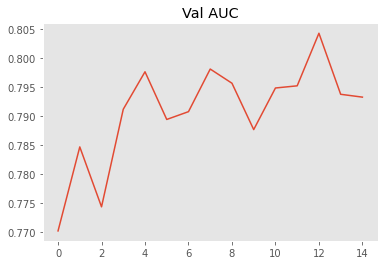

In [46]:
plt.plot(val_AUCs)
plt.title('Val AUC'); plt.grid(); plt.show()

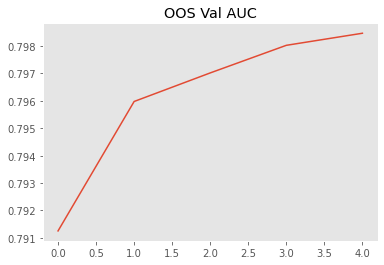

In [47]:
plt.plot(oos_val_AUCs)
plt.title('OOS Val AUC'); plt.grid(); plt.show()

In [48]:
print (80*'='); print(f'GLOBAL TIME: {time.time()-TIC:.1f} sec'); print(80*'=')

GLOBAL TIME: 9704.8 sec


## Feature Importance

In [49]:
y_true, y_pred = [],[]
for el in val_ds: 
    idx = get_last_t(el)
    y_true.append(tf.gather(el[:, :, ds_po.y_true], idx, batch_dims=1, axis=1))
    y_pred.append(tf.gather(transformer(el, training=False), idx, batch_dims=1, axis=1))
AUC_true = roc_auc_score(np.concatenate(y_true), np.concatenate(y_pred))
print(AUC_true)

0.8037446294724413


In [50]:
def shuffle_tensor(arr, pos):
    arr = arr.numpy()
    f_slice = arr[:,:,pos].copy()
    f_shuffled = f_slice.reshape(-1)
    np.random.shuffle(f_shuffled)
    arr[:,:,pos] = f_shuffled.reshape(f_slice.shape)
    return arr

permuted_AUC = {}
for shuffle_pos, feature in enumerate(ds_features):
    y_true, y_pred = [],[]
    for el in val_ds: 
        
        idx = get_last_t(el)
        y_true.append(tf.gather(el[:, :, ds_po.y_true], idx, batch_dims=1, axis=1))

        el = shuffle_tensor(el, shuffle_pos)
        y_pred.append(tf.gather(transformer(el, training=False), idx, batch_dims=1, axis=1))

    permuted_AUC[feature] = roc_auc_score(np.concatenate(y_true), np.concatenate(y_pred))

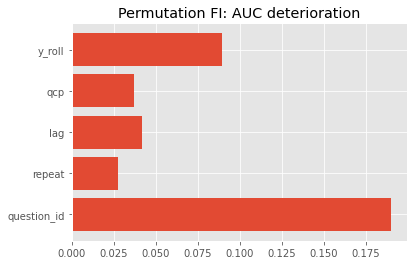

In [51]:
fi = {}
for k in permuted_AUC.keys():  
    if k == 'y_true': continue
    fi[k] = AUC_true - permuted_AUC[k]

plt.barh(list(fi.keys()), list(fi.values()))
plt.title('Permutation FI: AUC deterioration')
plt.show()